<a href="https://colab.research.google.com/github/yamatai-wizard/GCI_Competition2/blob/test/NFL_Draft_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第2回データ分析コンペティション：NFL Draft Prediction

## 目次
1. セットアップ
2. データ読み込み
3. データの分析・EDA
4. 前処理
5. ベースラインモデル
6. 仮説と特徴量エンジニアリング
7. 提出ファイル作成
8. 今後の展望

## 1. セットアップ

In [1]:
from google.colab import drive,files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

!pip install optuna
import optuna
from optuna.samplers import TPESampler

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2. データ読み込み

In [4]:
PATH = '/content/drive/MyDrive/GCI/NFL Draft Prediction/'

train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [5]:
print('Train:', train.shape)
print('Test:', test.shape)

Train: (2781, 16)
Test: (696, 15)


In [6]:
train.head()

,Id,Year,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Player_Type,Position_Type,Position,Drafted
0,0,2011,21.0,Lehigh,1.9050,140.160042,5.39,59.69,29.0,251.46,7.91,4.94,offense,offensive_lineman,OG,1.0
1,1,2011,24.0,Abilene Christian,1.8288,87.089735,4.31,101.60,16.0,332.74,NaN,NaN,offense,backs_receivers,WR,1.0
2,2,2018,21.0,Colorado St.,1.8542,92.986436,4.51,91.44,10.0,309.88,6.95,4.37,offense,backs_receivers,WR,1.0
3,3,2010,21.0,East Carolina,1.9304,148.778297,5.09,76.20,39.0,254.00,8.12,4.71,defense,defensive_lineman,DT,1.0
4,4,2016,21.0,California,1.8796,92.079251,4.64,78.74,NaN,281.94,7.13,4.20,offense,backs_receivers,WR,1.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                2781 non-null   int64  
 1   Year              2781 non-null   int64  
 2   Age               2346 non-null   float64
 3   School            2781 non-null   object 
 4   Height            2781 non-null   float64
 5   Weight            2781 non-null   float64
 6   Sprint_40yd       2636 non-null   float64
 7   Vertical_Jump     2227 non-null   float64
 8   Bench_Press_Reps  2060 non-null   float64
 9   Broad_Jump        2200 non-null   float64
 10  Agility_3cone     1811 non-null   float64
 11  Shuttle           1869 non-null   float64
 12  Player_Type       2781 non-null   object 
 13  Position_Type     2781 non-null   object 
 14  Position          2781 non-null   object 
 15  Drafted           2781 non-null   float64
dtypes: float64(10), int64(2), object(4)
memory

## 3. データの分析・EDA

In [8]:
train.isnull().sum()

,0
Id,0
Year,0
Age,435
School,0
Height,0
Weight,0
Sprint_40yd,145
Vertical_Jump,554
Bench_Press_Reps,721
Broad_Jump,581


In [9]:
test.isnull().sum()

,0
Id,0
Year,0
Age,115
School,0
Height,0
Weight,0
Sprint_40yd,29
Vertical_Jump,143
Bench_Press_Reps,184
Broad_Jump,147


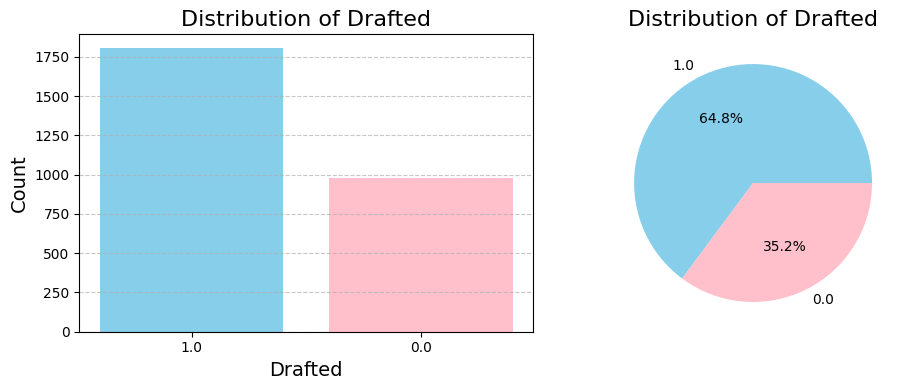

In [10]:
drafted_counts = train['Drafted'].value_counts()

fig, axes = plt.subplots(1,2,figsize=(10,4))
colors = ['skyblue','pink']

axes[0].bar(drafted_counts.index.astype(str),
            drafted_counts.values,
            color=colors)
axes[0].set_title('Distribution of Drafted', fontsize=16)
axes[0].set_xlabel('Drafted', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].pie(drafted_counts.values,
            labels=drafted_counts.index.astype(str),
            autopct='%1.1f%%',
            colors=colors)
axes[1].set_title('Distribution of Drafted', fontsize=16)

plt.tight_layout()
plt.show()

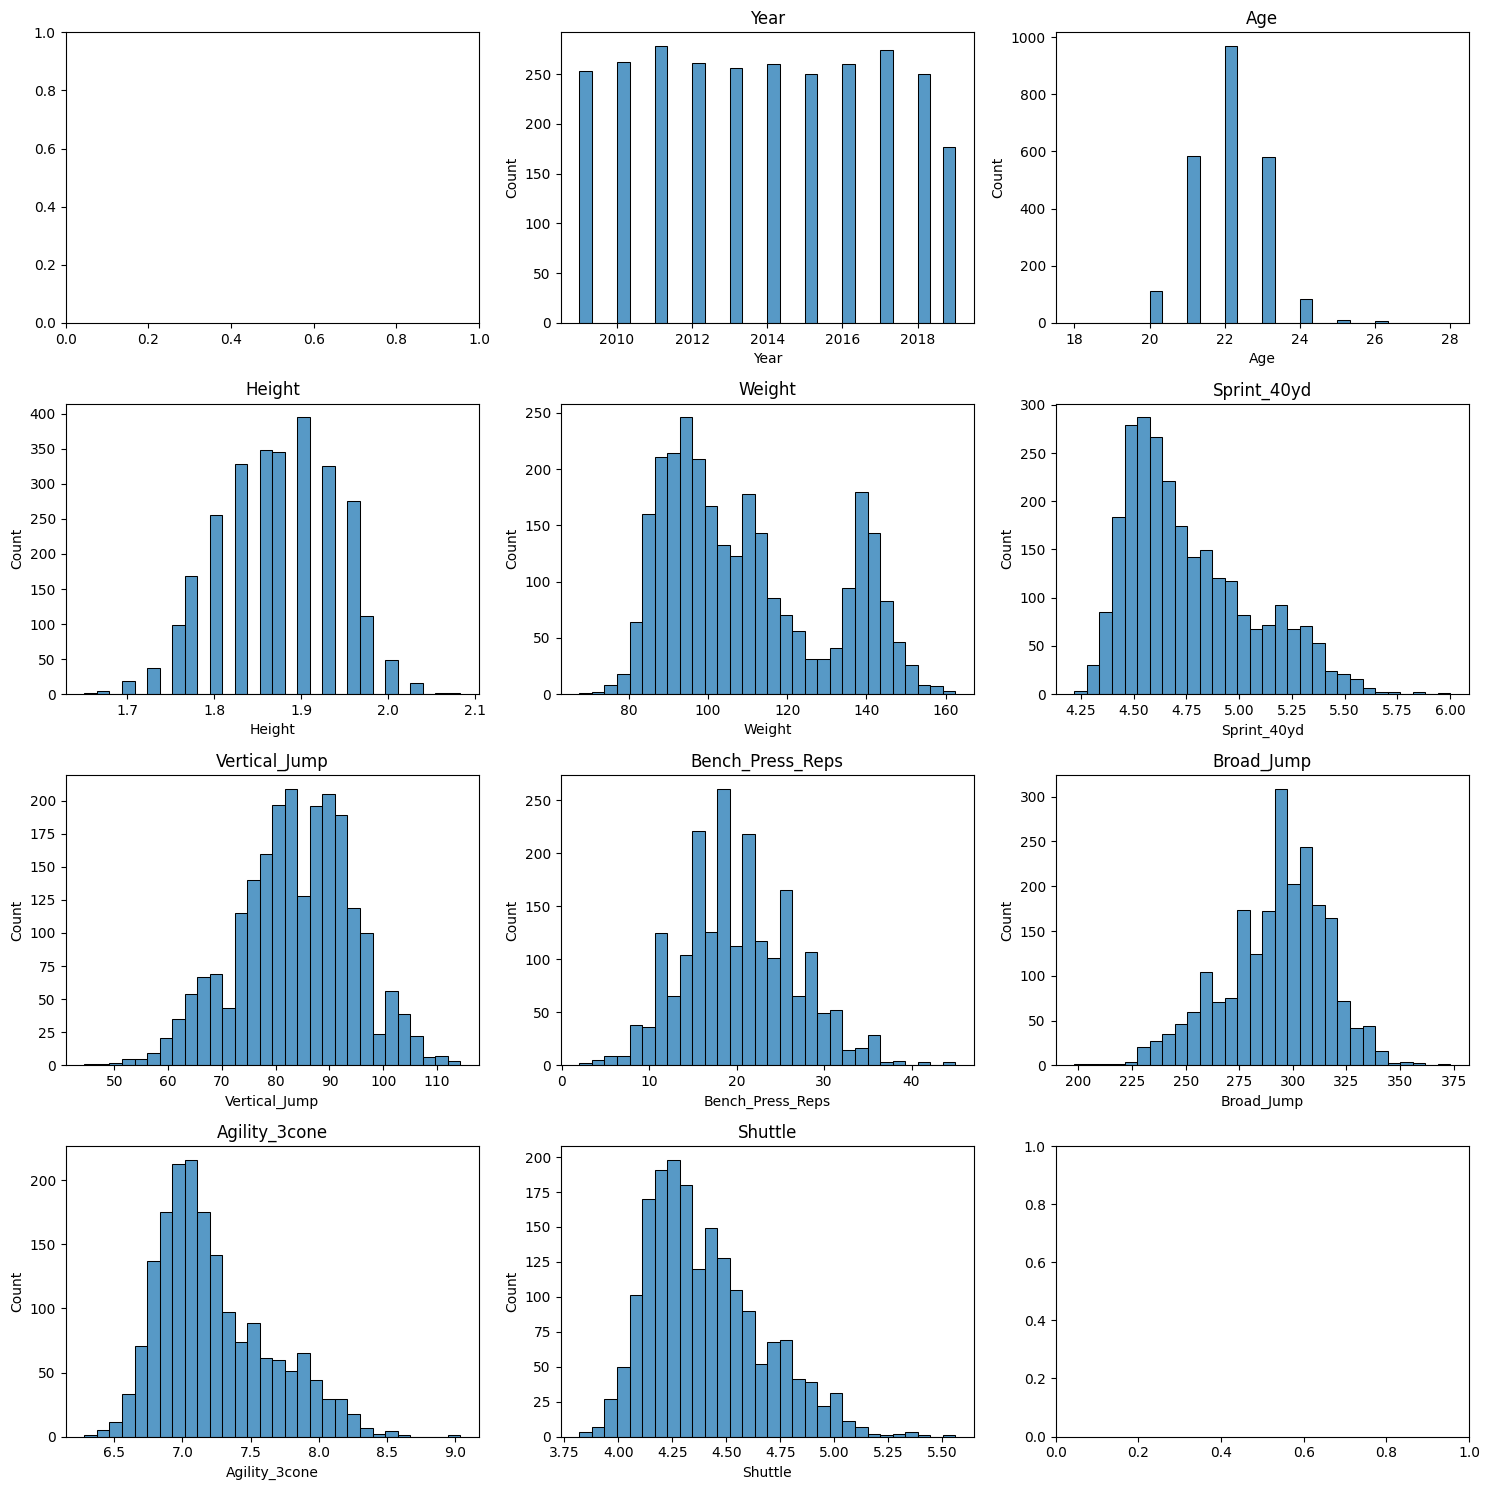

In [11]:
numeric_cols = train.select_dtypes(include='number').columns

fig, axes = plt.subplots(4,3,figsize=(15,15))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if col in ['Id','Drafted']:
        continue
    train_dropna = train.dropna(subset=[col])
    sns.histplot(data=train_dropna, x=col, bins=30,ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

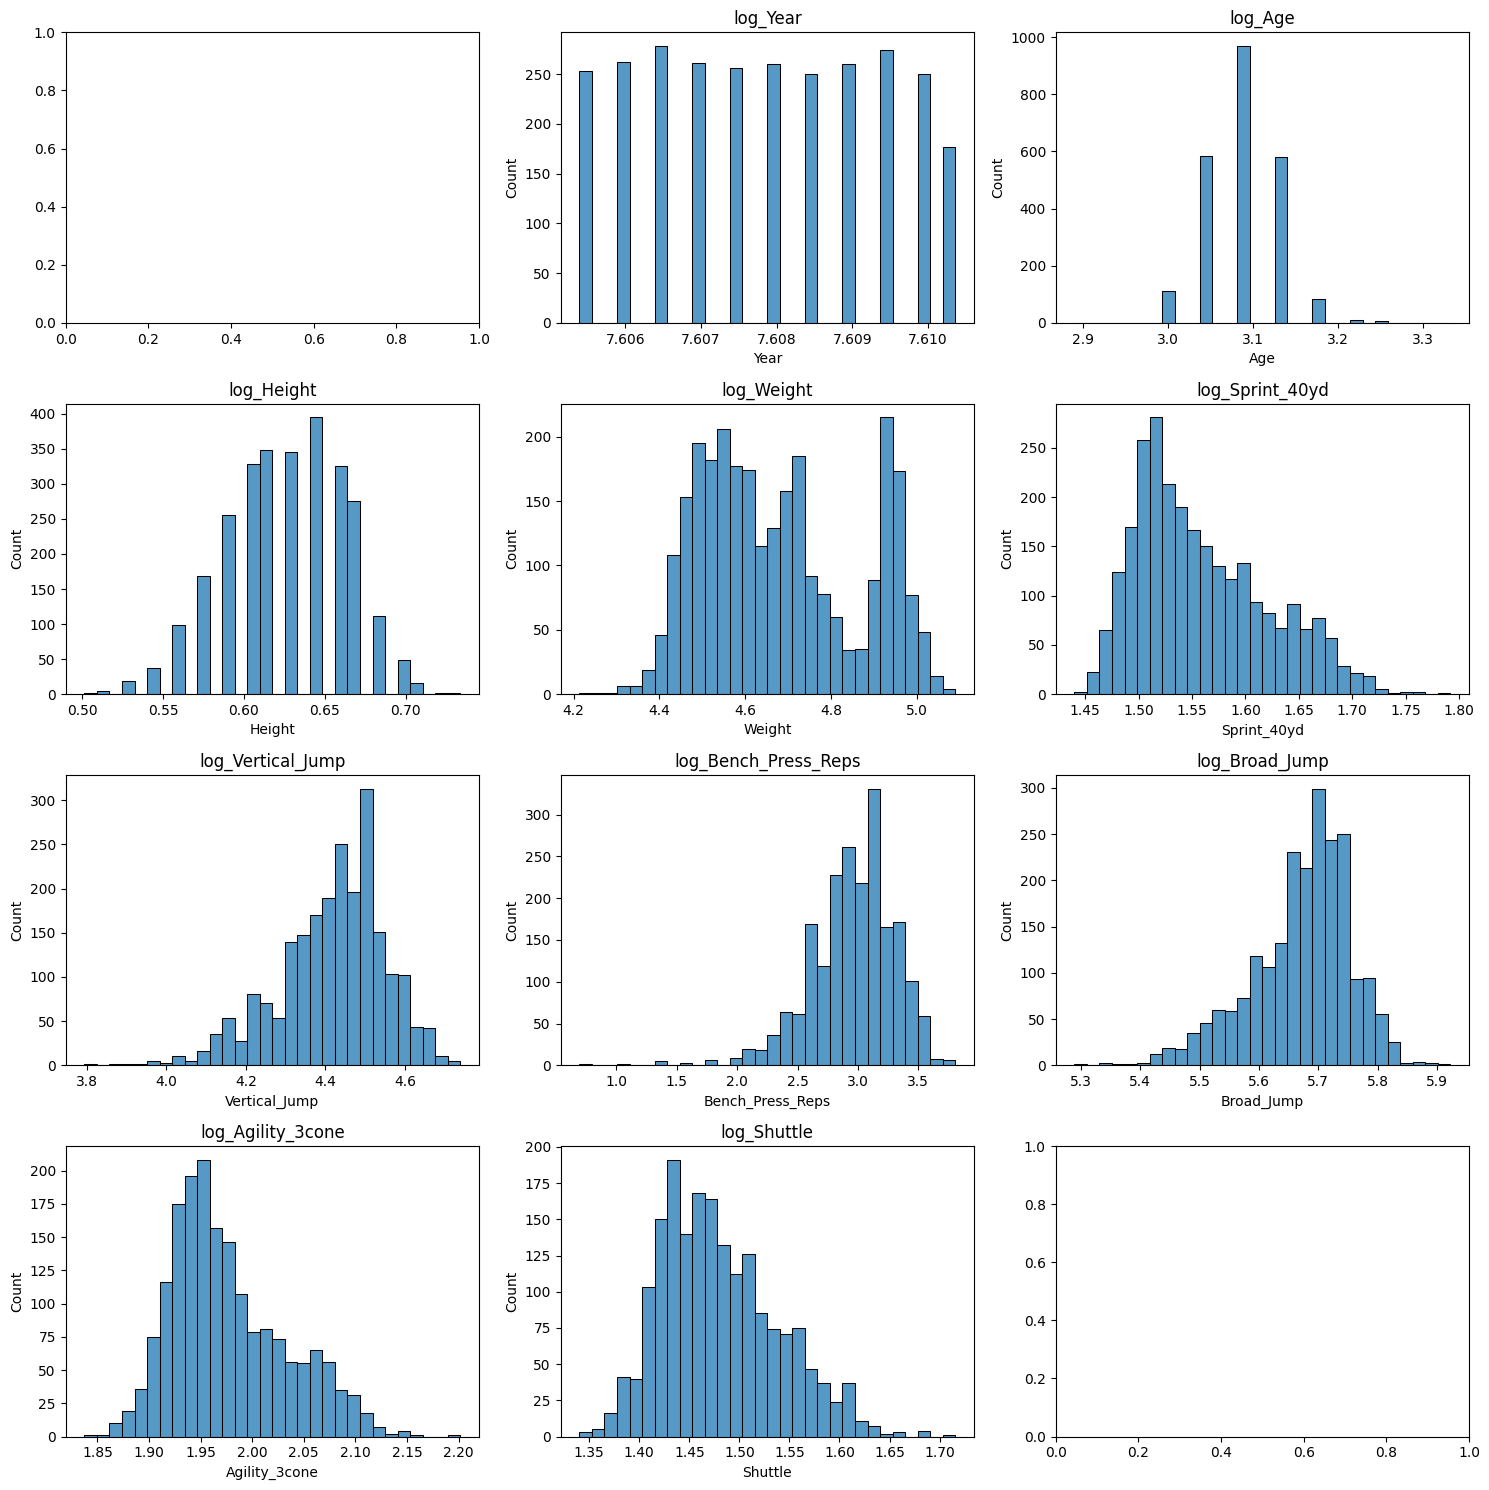

In [12]:
fig, axes = plt.subplots(4,3,figsize=(15,15))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if col in ['Id','Drafted']:
        continue
    train_dropna = train.dropna(subset=[col])
    log_col = np.log(train_dropna[col])
    sns.histplot(data=train_dropna, x=log_col, bins=30,ax=axes[i])
    axes[i].set_title(f'log_{col}')

plt.tight_layout()
plt.show()

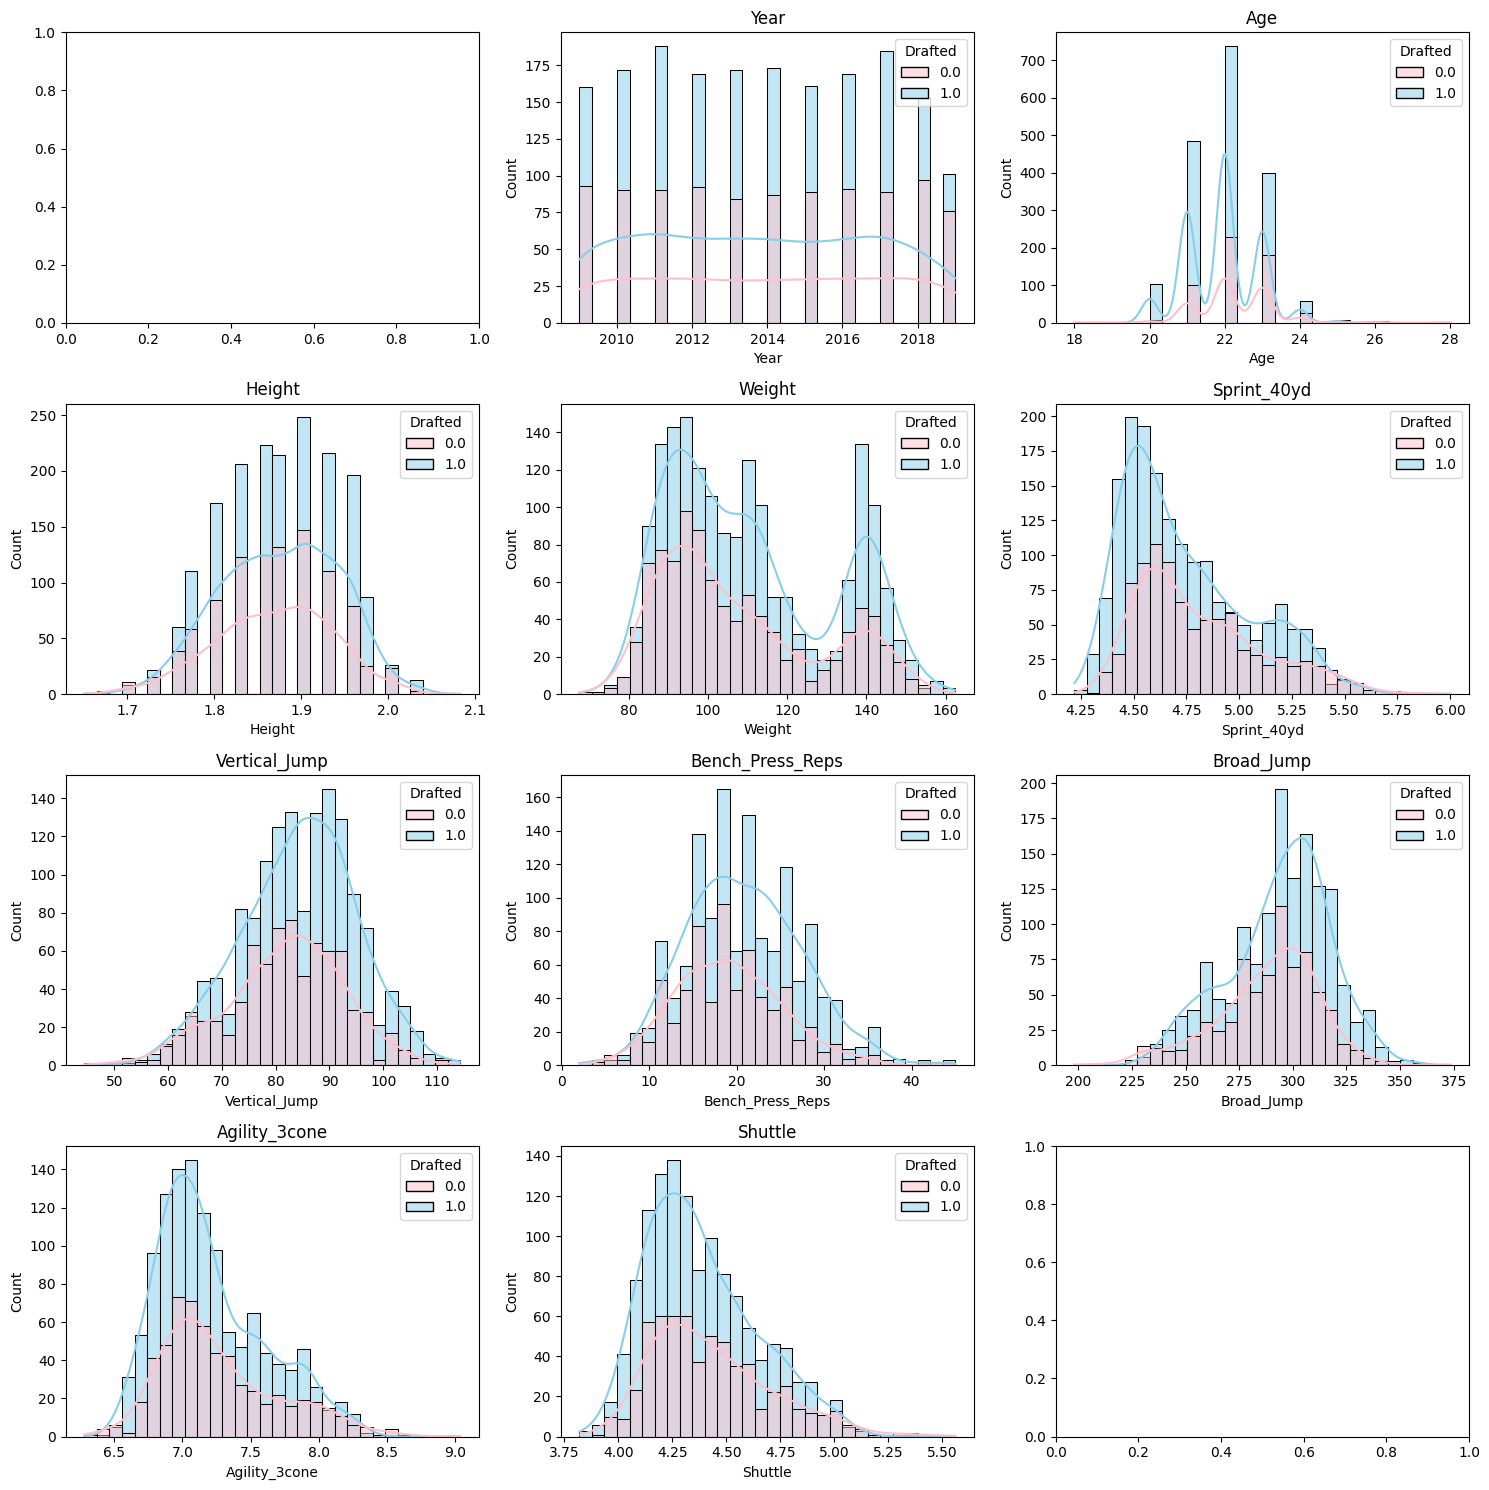

In [13]:
numeric_cols = train.select_dtypes(include='number').columns

fig, axes = plt.subplots(4,3,figsize=(15,15))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if col in ['Id','Drafted']:
        continue
    train_dropna = train.dropna(subset=[col])
    sns.histplot(data=train_dropna, x=col, bins=30, hue='Drafted',kde=True,ax=axes[i],palette={0: 'pink', 1: 'skyblue'})
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

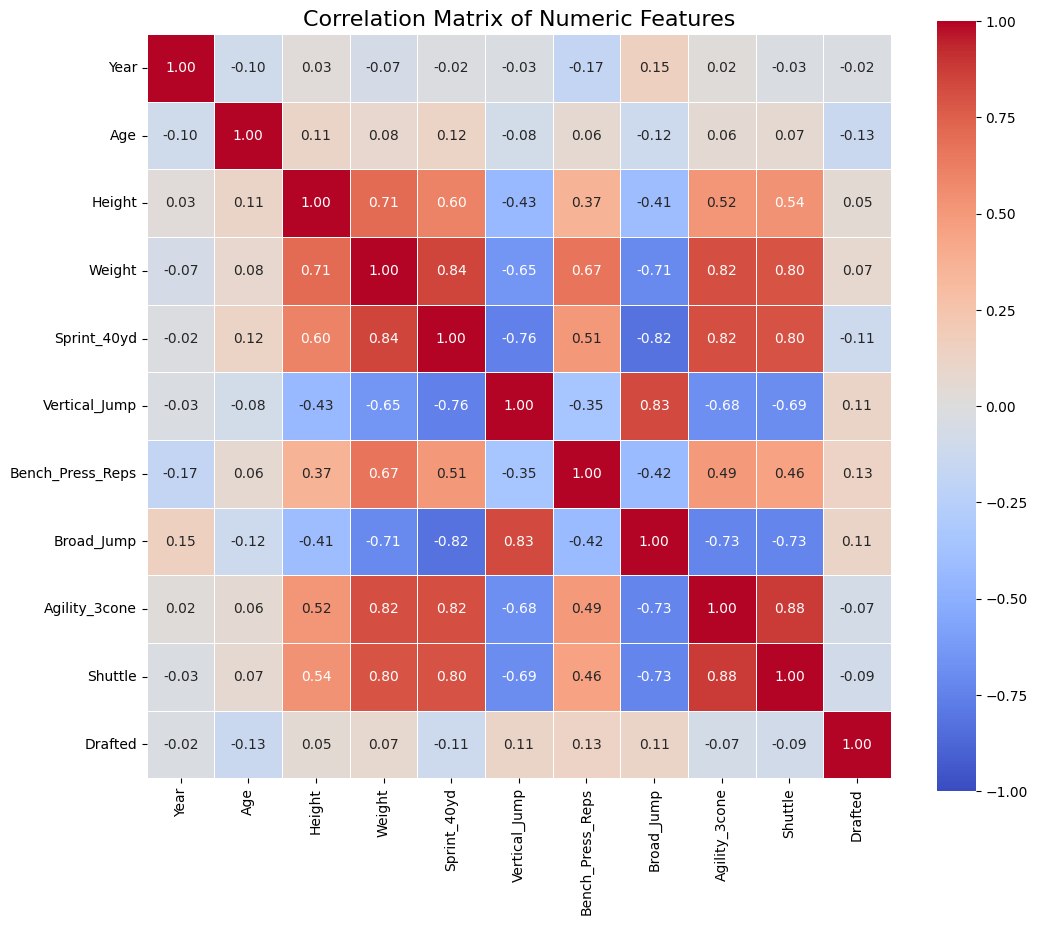

In [14]:
numeric_cols = train.select_dtypes(include=['number']).drop(['Id'], axis=1)

corr_matrix = numeric_cols.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)

plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()

In [15]:
# カテゴリデータを抽出
categorical_cols = train.select_dtypes(include='object').columns

# 各列の水準数を取得
levels_count = {col: train[col].nunique() for col in categorical_cols}

for col, count in levels_count.items():
    print(f"{col}: {count} levels")


School: 236 levels
Player_Type: 3 levels
Position_Type: 7 levels
Position: 20 levels


In [16]:
train.groupby('School')['School'].size().sort_values(ascending=False)

,School
School,
Alabama,73
LSU,70
USC,63
Ohio St.,59
Florida St.,57
Clemson,57
Georgia,54
Oklahoma,54
Miami (FL),54


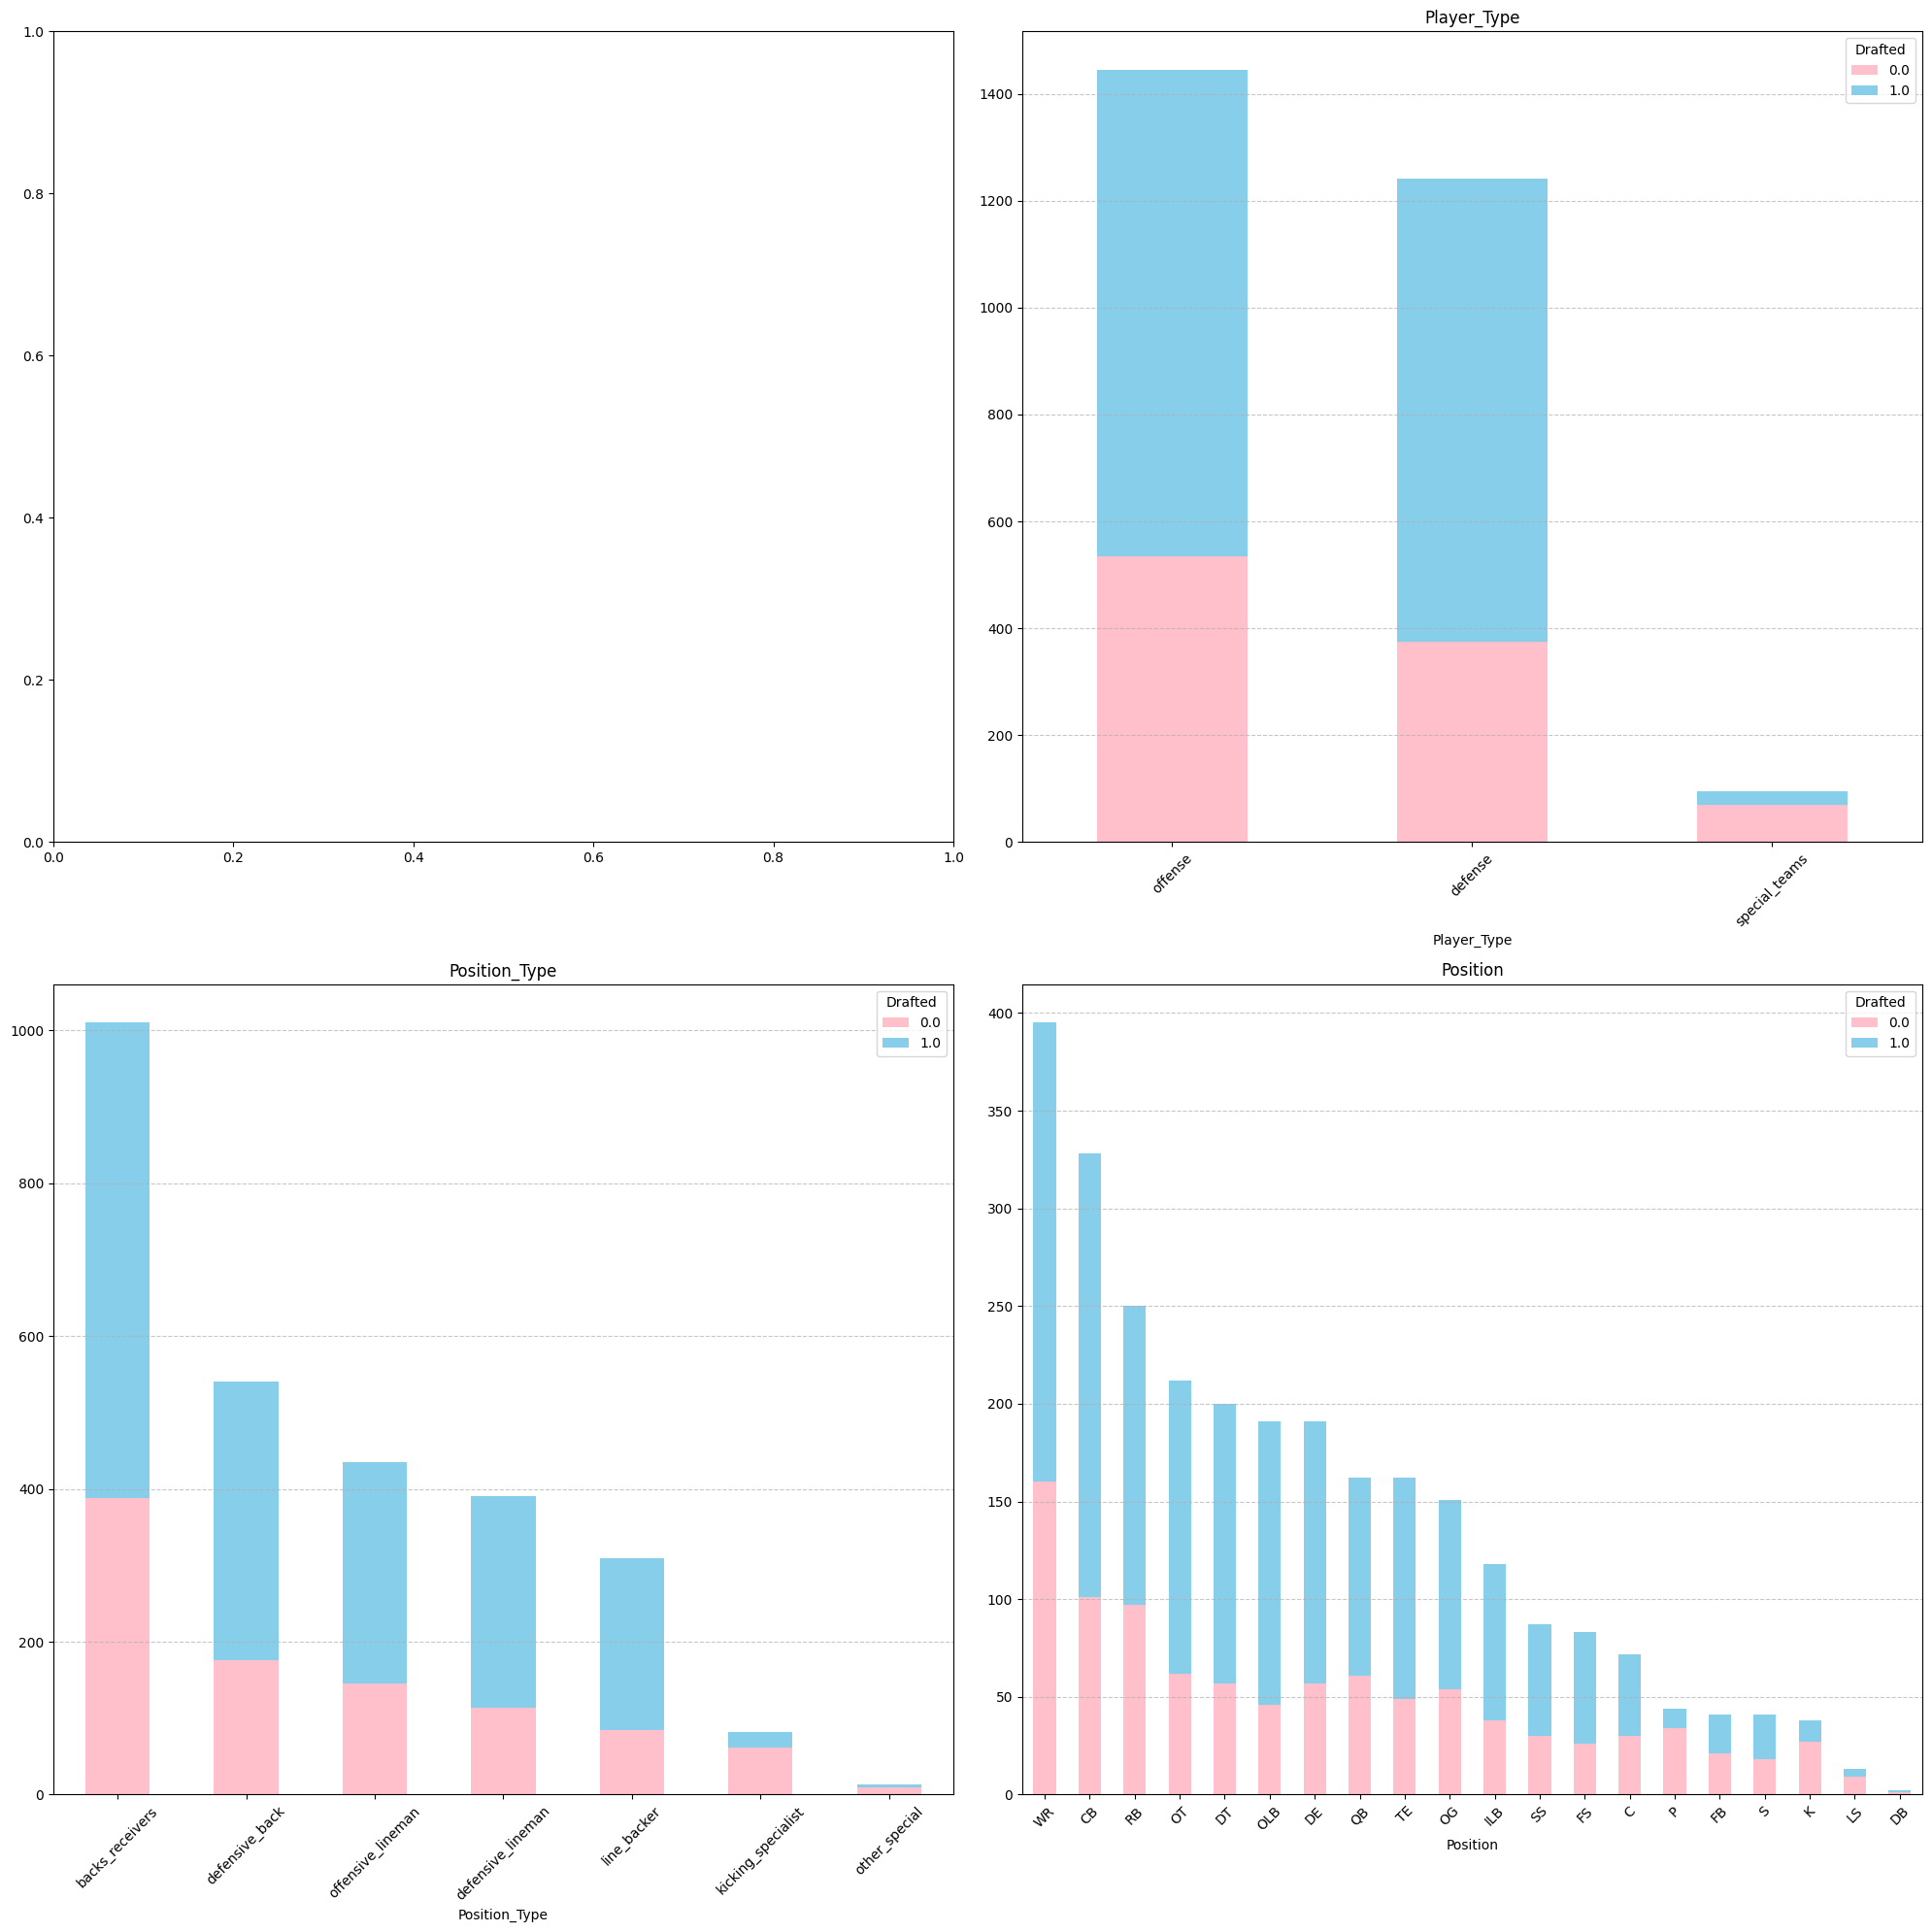

In [17]:
categorical_cols = train.select_dtypes(include='object').columns

fig, axes = plt.subplots(2, 2, figsize=(20,20))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col in ['School']:
        continue
    cross_tab = pd.crosstab(train[col], train['Drafted'])
    cross_tab['Total'] = cross_tab.sum(axis=1)
    sorted_cross_tab =cross_tab.sort_values(by='Total', ascending=False).drop(columns='Total')

    sorted_cross_tab.plot.bar(
        stacked=True,
        ax=axes[i],
        color=['pink', 'skyblue'],
        rot=45
    )

    axes[i].set_title(col)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].legend(title='Drafted')

plt.tight_layout()
plt.show()

## 4. 前処理

In [18]:
# 使わない列の削除
train = train.drop(columns=["Id", "School"])
test = test.drop(columns=["Id","School"])

In [19]:
# 平均で補完する対象の列
cols_to_fill = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# train の平均で train/test 両方を補完
for col in cols_to_fill:
    mean_value = train[col].mean()
    train[col] = train[col].fillna(mean_value)
    test[col] = test[col].fillna(mean_value)

In [20]:
train.isnull().sum()

,0
Year,0
Age,0
Height,0
Weight,0
Sprint_40yd,0
Vertical_Jump,0
Bench_Press_Reps,0
Broad_Jump,0
Agility_3cone,0
Shuttle,0


In [21]:
test.isnull().sum()

,0
Year,0
Age,0
Height,0
Weight,0
Sprint_40yd,0
Vertical_Jump,0
Bench_Press_Reps,0
Broad_Jump,0
Agility_3cone,0
Shuttle,0


In [22]:
# カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Player_Type", "Position_Type", "Position"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

## 5. 複数モデルの検証

In [23]:
X = train.drop(columns=['Drafted'])
y = train['Drafted']

sampler = TPESampler(seed=42)

def objective(trial, model_name):
    if model_name == "RandomForest":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif model_name == "LightGBM":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 255),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }
        model = LGBMClassifier(**params, random_state=42, verbosity=-1)

    elif model_name == "XGBoost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }
        model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss', verbosity=0)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

best_params = {}
for model_name in ["RandomForest", "LightGBM", "XGBoost"]:
    study = optuna.create_study(direction='maximize', sampler=sampler)
    objective_func = lambda trial: objective(trial, model_name)
    study.optimize(objective_func, n_trials=50, n_jobs=1)

    best_params[model_name] = study.best_params
    print(f"{model_name} best params: {study.best_params}")
    print(f"Best AUC: {study.best_value:.4f}\n")

optimized_models = {
    "RandomForest": RandomForestClassifier(**best_params["RandomForest"], random_state=42),
    "LightGBM": LGBMClassifier(**best_params["LightGBM"], random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(**best_params["XGBoost"], random_state=42,
                             use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in optimized_models.items():
    print(f'\n==={model_name}===')
    auc_scores = []
    test_pred_proba_list = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f'Fold{fold+1}')

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)

        y_valid_pred_proba = model.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, y_valid_pred_proba)
        auc_scores.append(auc)
        print(f'AUC:{round(auc,4)}')

        test_pred_proba = model.predict_proba(test)[:,1]
        test_pred_proba_list.append(test_pred_proba)

    mean_auc = np.mean(auc_scores)
    print("\nAverage Validation AUC:", round(mean_auc, 4))

    test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

    results[model_name] = {
        'auc_scores': auc_scores,
        'mean_auc': mean_auc,
        'test_pred_proba': test_pred_proba_mean
    }

print('\n=== Optimized Model Comparison ===')
for model_name, res in results.items():
    print(f"{model_name}: AUC = {round(res['mean_auc'], 4)}")

[I 2025-06-20 16:02:46,192] A new study created in memory with name: no-name-1514e964-888c-4092-990f-fce7eeba124c
[I 2025-06-20 16:02:48,182] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 218, 'max_depth': 15, 'min_samples_split': 0.7346740023932911, 'min_samples_leaf': 0.30334265725654797, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.5.
[I 2025-06-20 16:02:50,295] Trial 1 finished with value: 0.5884497210348022 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 0.9702107536403743, 'min_samples_leaf': 0.41789689399220664, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.5884497210348022.
[I 2025-06-20 16:02:52,786] Trial 2 finished with value: 0.7516725678303142 and parameters: {'n_estimators': 244, 'max_depth': 6, 'min_samples_split': 0.6157343657751557, 'min_samples_leaf': 0.0783519917195005, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.7516725678303142.
[I 20

RandomForest best params: {'n_estimators': 345, 'max_depth': 6, 'min_samples_split': 0.08428142846924094, 'min_samples_leaf': 0.033174915692184864, 'max_features': 'sqrt', 'bootstrap': True}
Best AUC: 0.8016



[I 2025-06-20 16:06:48,821] Trial 0 finished with value: 0.8159239499123749 and parameters: {'n_estimators': 103, 'max_depth': 12, 'learning_rate': 0.13297554090738672, 'num_leaves': 150, 'min_child_samples': 79, 'subsample': 0.7468977981821954, 'colsample_bytree': 0.7613664146909971}. Best is trial 0 with value: 0.8159239499123749.
[I 2025-06-20 16:06:49,154] Trial 1 finished with value: 0.8193947343657969 and parameters: {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.01443340240633889, 'num_leaves': 22, 'min_child_samples': 66, 'subsample': 0.6571779905381634, 'colsample_bytree': 0.7542853455823514}. Best is trial 1 with value: 0.8193947343657969.
[I 2025-06-20 16:06:50,042] Trial 2 finished with value: 0.8113542845933033 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.040381768820718394, 'num_leaves': 197, 'min_child_samples': 26, 'subsample': 0.5384899549143964, 'colsample_bytree': 0.6448757264568841}. Best is trial 1 with value: 0.819394734365796

LightGBM best params: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.02626579924783076, 'num_leaves': 213, 'min_child_samples': 67, 'subsample': 0.8095755951732363, 'colsample_bytree': 0.6945227963420672}
Best AUC: 0.8299



[I 2025-06-20 16:07:25,070] Trial 0 finished with value: 0.8184931554836581 and parameters: {'n_estimators': 215, 'max_depth': 11, 'learning_rate': 0.0862581622692092, 'subsample': 0.7678873420373793, 'colsample_bytree': 0.5451448850272042, 'gamma': 0.835302495589238, 'min_child_weight': 4}. Best is trial 0 with value: 0.8184931554836581.
[I 2025-06-20 16:07:25,389] Trial 1 finished with value: 0.8304240400258406 and parameters: {'n_estimators': 134, 'max_depth': 3, 'learning_rate': 0.07461403484816762, 'subsample': 0.8387821809211412, 'colsample_bytree': 0.508293914463928, 'gamma': 0.512093058299281, 'min_child_weight': 3}. Best is trial 1 with value: 0.8304240400258406.
[I 2025-06-20 16:07:26,285] Trial 2 finished with value: 0.8058092865671022 and parameters: {'n_estimators': 340, 'max_depth': 5, 'learning_rate': 0.10485733570643786, 'subsample': 0.6933676731502687, 'colsample_bytree': 0.9683649943683672, 'gamma': 0.13752094414599325, 'min_child_weight': 4}. Best is trial 1 with val

XGBoost best params: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.015063020802971968, 'subsample': 0.7971817653040668, 'colsample_bytree': 0.5515002719111546, 'gamma': 0.38325255876910214, 'min_child_weight': 9}
Best AUC: 0.8313


===RandomForest===
Fold1
AUC:0.7775
Fold2
AUC:0.8263
Fold3
AUC:0.8215
Fold4
AUC:0.7635
Fold5
AUC:0.8194

Average Validation AUC: 0.8016

===LightGBM===
Fold1
AUC:0.8092
Fold2
AUC:0.8483
Fold3
AUC:0.8479
Fold4
AUC:0.7982
Fold5
AUC:0.8458

Average Validation AUC: 0.8299

===XGBoost===
Fold1
AUC:0.8124
Fold2
AUC:0.8521
Fold3
AUC:0.85
Fold4
AUC:0.7905
Fold5
AUC:0.8514

Average Validation AUC: 0.8313

=== Optimized Model Comparison ===
RandomForest: AUC = 0.8016
LightGBM: AUC = 0.8299
XGBoost: AUC = 0.8313


## 6. 仮説と特徴量エンジニアリング

In [24]:
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [25]:
X = train.drop(columns=['Drafted'])
y = train['Drafted']

sampler = TPESampler(seed=42)

def objective(trial, model_name):
    if model_name == "RandomForest":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif model_name == "LightGBM":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 255),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }
        model = LGBMClassifier(**params, random_state=42, verbosity=-1)

    elif model_name == "XGBoost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }
        model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss', verbosity=0)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

best_params = {}
for model_name in ["RandomForest", "LightGBM", "XGBoost"]:
    study = optuna.create_study(direction='maximize', sampler=sampler)
    objective_func = lambda trial: objective(trial, model_name)
    study.optimize(objective_func, n_trials=50, n_jobs=1)

    best_params[model_name] = study.best_params
    print(f"{model_name} best params: {study.best_params}")
    print(f"Best AUC: {study.best_value:.4f}\n")

optimized_models = {
    "RandomForest": RandomForestClassifier(**best_params["RandomForest"], random_state=42),
    "LightGBM": LGBMClassifier(**best_params["LightGBM"], random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(**best_params["XGBoost"], random_state=42,
                             use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in optimized_models.items():
    print(f'\n==={model_name}===')
    auc_scores = []
    test_pred_proba_list = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f'Fold{fold+1}')

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)

        y_valid_pred_proba = model.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, y_valid_pred_proba)
        auc_scores.append(auc)
        print(f'AUC:{round(auc,4)}')

        test_pred_proba = model.predict_proba(test)[:,1]
        test_pred_proba_list.append(test_pred_proba)

    mean_auc = np.mean(auc_scores)
    print("\nAverage Validation AUC:", round(mean_auc, 4))

    test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

    results[model_name] = {
        'auc_scores': auc_scores,
        'mean_auc': mean_auc,
        'test_pred_proba': test_pred_proba_mean
    }

print('\n=== Optimized Model Comparison ===')
for model_name, res in results.items():
    print(f"{model_name}: AUC = {round(res['mean_auc'], 4)}")

[I 2025-06-20 16:08:14,756] A new study created in memory with name: no-name-fd18afc7-af2d-446e-a91c-58b4b296816d
[I 2025-06-20 16:08:16,814] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 218, 'max_depth': 15, 'min_samples_split': 0.7346740023932911, 'min_samples_leaf': 0.30334265725654797, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.5.
[I 2025-06-20 16:08:19,262] Trial 1 finished with value: 0.5934141225920015 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 0.9702107536403743, 'min_samples_leaf': 0.41789689399220664, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.5934141225920015.
[I 2025-06-20 16:08:21,962] Trial 2 finished with value: 0.7516725678303142 and parameters: {'n_estimators': 244, 'max_depth': 6, 'min_samples_split': 0.6157343657751557, 'min_samples_leaf': 0.0783519917195005, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.7516725678303142.
[I 20

RandomForest best params: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 0.11851472429052816, 'min_samples_leaf': 0.013153819732646371, 'max_features': 'sqrt', 'bootstrap': True}
Best AUC: 0.8121



[I 2025-06-20 16:12:59,977] Trial 0 finished with value: 0.815538270319137 and parameters: {'n_estimators': 103, 'max_depth': 12, 'learning_rate': 0.13297554090738672, 'num_leaves': 150, 'min_child_samples': 79, 'subsample': 0.7468977981821954, 'colsample_bytree': 0.7613664146909971}. Best is trial 0 with value: 0.815538270319137.
[I 2025-06-20 16:13:00,329] Trial 1 finished with value: 0.8180859676422598 and parameters: {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.01443340240633889, 'num_leaves': 22, 'min_child_samples': 66, 'subsample': 0.6571779905381634, 'colsample_bytree': 0.7542853455823514}. Best is trial 1 with value: 0.8180859676422598.
[I 2025-06-20 16:13:01,264] Trial 2 finished with value: 0.8109804097432709 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.040381768820718394, 'num_leaves': 197, 'min_child_samples': 26, 'subsample': 0.5384899549143964, 'colsample_bytree': 0.6448757264568841}. Best is trial 1 with value: 0.8180859676422598.

LightGBM best params: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.04586573377977283, 'num_leaves': 209, 'min_child_samples': 77, 'subsample': 0.5781255602681828, 'colsample_bytree': 0.5983585334570112}
Best AUC: 0.8294



[I 2025-06-20 16:13:35,698] Trial 0 finished with value: 0.8138450437352297 and parameters: {'n_estimators': 215, 'max_depth': 11, 'learning_rate': 0.0862581622692092, 'subsample': 0.7678873420373793, 'colsample_bytree': 0.5451448850272042, 'gamma': 0.835302495589238, 'min_child_weight': 4}. Best is trial 0 with value: 0.8138450437352297.
[I 2025-06-20 16:13:36,032] Trial 1 finished with value: 0.825855630376307 and parameters: {'n_estimators': 134, 'max_depth': 3, 'learning_rate': 0.07461403484816762, 'subsample': 0.8387821809211412, 'colsample_bytree': 0.508293914463928, 'gamma': 0.512093058299281, 'min_child_weight': 3}. Best is trial 1 with value: 0.825855630376307.
[I 2025-06-20 16:13:37,038] Trial 2 finished with value: 0.8103278179302121 and parameters: {'n_estimators': 340, 'max_depth': 5, 'learning_rate': 0.10485733570643786, 'subsample': 0.6933676731502687, 'colsample_bytree': 0.9683649943683672, 'gamma': 0.13752094414599325, 'min_child_weight': 4}. Best is trial 1 with value

XGBoost best params: {'n_estimators': 347, 'max_depth': 7, 'learning_rate': 0.015975050582646016, 'subsample': 0.5822384379538845, 'colsample_bytree': 0.6108241645364059, 'gamma': 0.43701483230275484, 'min_child_weight': 6}
Best AUC: 0.8312


===RandomForest===
Fold1
AUC:0.7757
Fold2
AUC:0.8317
Fold3
AUC:0.8376
Fold4
AUC:0.7863
Fold5
AUC:0.8293

Average Validation AUC: 0.8121

===LightGBM===
Fold1
AUC:0.8081
Fold2
AUC:0.8437
Fold3
AUC:0.8471
Fold4
AUC:0.8023
Fold5
AUC:0.8456

Average Validation AUC: 0.8294

===XGBoost===
Fold1
AUC:0.8028
Fold2
AUC:0.8563
Fold3
AUC:0.8518
Fold4
AUC:0.7969
Fold5
AUC:0.8482

Average Validation AUC: 0.8312

=== Optimized Model Comparison ===
RandomForest: AUC = 0.8121
LightGBM: AUC = 0.8294
XGBoost: AUC = 0.8312


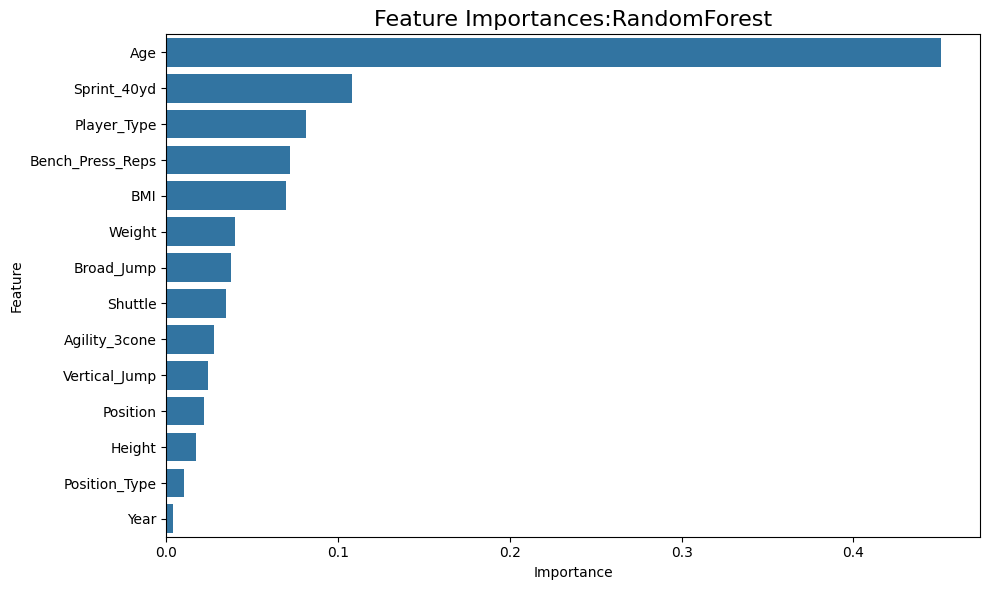

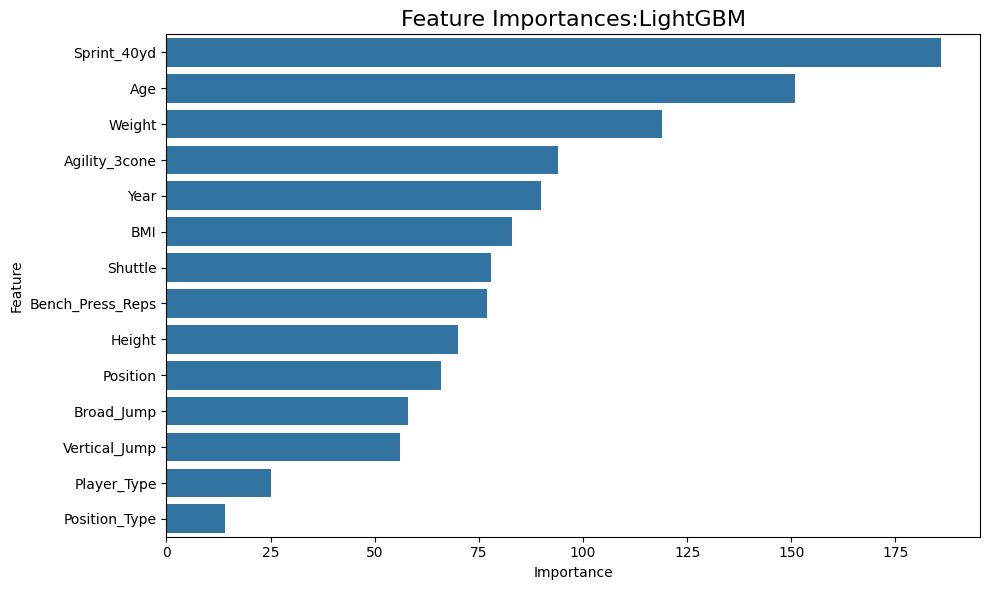

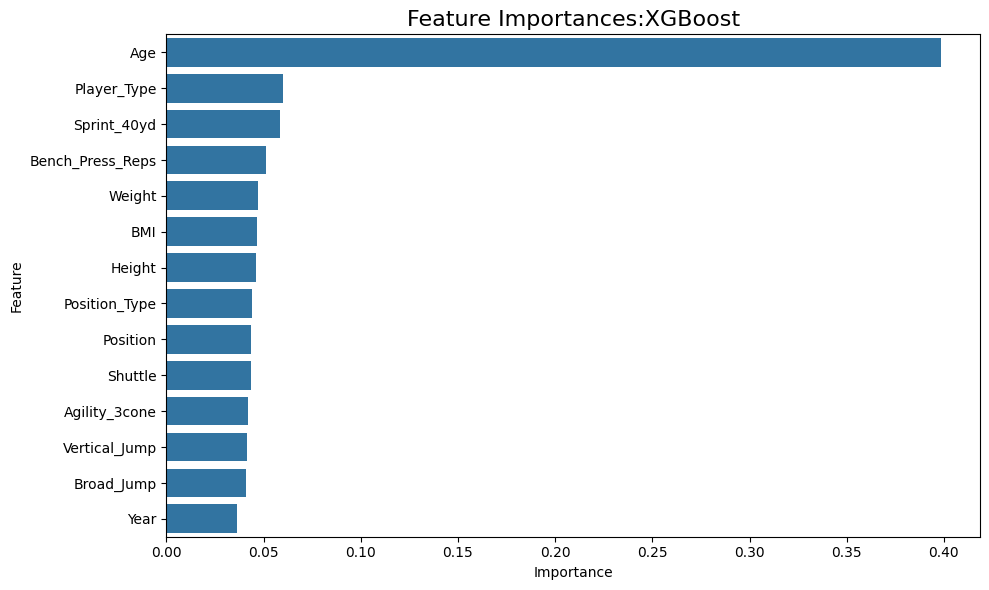

In [26]:
for model_name, model in optimized_models.items():
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importances, x='Importance', y='Feature')
    plt.title(f'Feature Importances:{model_name}', fontsize=16)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
import numpy as np

# 各モデルのテスト予測を取得
rf_preds = results["RandomForest"]['test_pred_proba']
lgb_preds = results["LightGBM"]['test_pred_proba']
xgb_preds = results["XGBoost"]['test_pred_proba']

# 重みの最適化関数
def optimize_weights(y_true, preds_list):
    best_score = 0
    best_weights = None

    # グリッドサーチで最適な重みを探索
    for w1 in np.linspace(0, 1, 11):
        for w2 in np.linspace(0, 1 - w1, 11):
            w3 = 1 - w1 - w2
            if w3 < 0: continue

            ensemble_preds = w1 * preds_list[0] + w2 * preds_list[1] + w3 * preds_list[2]
            score = roc_auc_score(y_true, ensemble_preds)

            if score > best_score:
                best_score = score
                best_weights = (w1, w2, w3)

    return best_weights, best_score

# バリデーションデータで重み最適化
val_preds = {
    "RandomForest": np.zeros(len(y)),
    "LightGBM": np.zeros(len(y)),
    "XGBoost": np.zeros(len(y))
}

# 各モデルのOOF予測を収集
for model_name, model in optimized_models.items():
    oof_preds = np.zeros(len(y))
    model = model  # 最適化済みモデル

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        fold_preds = model.predict_proba(X_valid)[:, 1]
        oof_preds[valid_idx] = fold_preds

    val_preds[model_name] = oof_preds

# 重み最適化
best_weights, best_score = optimize_weights(
    y,
    [val_preds["RandomForest"], val_preds["LightGBM"], val_preds["XGBoost"]]
)

print(f"Optimal weights: RF={best_weights[0]:.2f}, LGB={best_weights[1]:.2f}, XGB={best_weights[2]:.2f}")
print(f"Validation AUC with optimized weights: {best_score:.4f}")

# テストデータでのアンサンブル予測
ensemble_test_preds = (
    best_weights[0] * rf_preds +
    best_weights[1] * lgb_preds +
    best_weights[2] * xgb_preds
)

# メタデータセットの作成
meta_X = np.column_stack([
    val_preds["RandomForest"],
    val_preds["LightGBM"],
    val_preds["XGBoost"]
])

# メタモデルの訓練
meta_model = LogisticRegression()
meta_model.fit(meta_X, y)

# テストデータのメタ特徴量
test_meta_X = np.column_stack([rf_preds, lgb_preds, xgb_preds])

# メタモデルでの予測
stacking_preds = meta_model.predict_proba(test_meta_X)[:, 1]

Optimal weights: RF=0.00, LGB=0.30, XGB=0.70
Validation AUC with optimized weights: 0.8310


## 7. 提出ファイル作成

In [28]:
submission = pd.read_csv(PATH + 'sample_submission.csv')
submission["Drafted"] = stacking_preds
submission.to_csv(PATH + 'submission.csv', index=False)

files.download(PATH + 'submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8. 今後の展望

　本ノートブックでは、データの前処理から特徴量エンジニアリング、モデル構築、評価まで、ベースラインモデルの構築を行いました。

　今後はこのベースラインを土台として、さらに高度な特徴量の工夫やアルゴリズムの改善などによって精度向上を目指していくことができます。例えば、以下のような工夫が考えられます。

- カテゴリデータのエンコーディング手法の変更
- 欠損値の補完手法の変更
- 別のモデルの検討
- モデルのハイパーパラメータ調整
- 特徴量エンジニアリング


　高スコア獲得を目指して、頑張りましょう！